In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def create_data(version_1_sample=1200, version_2_sample=1200):
    '''
    inputs:
        version_1_sample: (int) number of people given landing page version 1
        version_2_sample: (int) number of people given landing page version 2

    returns:
        df: (DataFrame) with the description given below
        
    This function builds a dataframe with columns for:

                |              |              |         |
        user_id | page_version | clickthrough | convert | revenue
        ----------------------------------------------------------

    user_id: (int) a unique user id
    page_version: (int) the page version is either landing page version 1 or 2
    clickthrough: (int) is whether or not the user clicked through the homepage 0 or 1
    convert: (int) is whether or not the user converted 0 or 1
    revenue: (int) is a dollar amount associated with the product conversion amount
    
    '''
    np.random.seed(42) # set the seed to always create the same dataframe
    df = pd.DataFrame() # create an empty dataframe to store the results

    # create user and version columns
    df['user_id'] = list(range(version_1_sample + version_2_sample))
    df['page_version'] = list(np.repeat(1, version_1_sample)) + list(np.repeat(2, version_2_sample))

    # values for the convert column
    result_1 = np.random.binomial(1, 0.10, version_1_sample)
    result_2 = np.random.binomial(1, 0.07, version_2_sample)
    df['convert'] = list(result_1) + list(result_2)

    # values for the clickthrough from the landing page
    df['clickthrough'] = df['convert']
    for idx in df.query('clickthrough == 0').index:
        df.loc[idx, 'clickthrough'] = np.random.binomial(1, 0.3, 1)[0]

    # values for the revenue column
    df['revenue'] = 0
    product_prices = [20, 40, 60, 80, 100, 150]
    odds_result_1 = [0.5, 0.2, 0.1, 0.1, 0.05, 0.05]
    odds_result_2 = [0.3, 0.1, 0.1, 0.1, 0.2, 0.2]
    for idx in df.query('convert == 1 and page_version == 1').index:
        df.loc[idx, 'revenue'] = np.random.choice(product_prices, 1, p=odds_result_1)    
    for idx in df.query('convert == 1 and page_version == 2').index:
        df.loc[idx, 'revenue'] = np.random.choice(product_prices, 1, p=odds_result_2)    

    # shuffle the order of the dataframe  rows and reorder the columns
    df = df.sample(frac=1, random_state=42)
    df = df[['user_id', 'page_version', 'clickthrough', 'convert' , 'revenue']]

    return df

df = create_data(10000, 10000)
df.head()

,user_id,page_version,clickthrough,convert,revenue
10650,10650,2,1,1,20
2041,2041,1,0,0,0
8668,8668,1,0,0,0
1114,1114,1,1,0,0
13902,13902,2,0,0,0


In [3]:
df.query('page_version == 1')['revenue'].mean(), df.query('page_version == 2').revenue.mean()

(4.202, 5.316)

In [4]:
df.query('page_version == 1')['revenue'].count(), df.query('page_version == 2').revenue.count()

(10000, 10000)

In [5]:
df.query('page_version == 1')['revenue'].var(), df.query('page_version == 2').revenue.var()

(271.0503010301234, 530.2731713170944)

In [6]:
from scipy import stats

stats.ttest_ind(df.query('page_version == 1').revenue, df.query('page_version == 2').revenue)

Ttest_indResult(statistic=-3.9353309278564597, pvalue=8.336307006191437e-05)

In [8]:
(df.query('page_version == 1').revenue.mean() - df.query('page_version == 2')['revenue'].mean())/-3.9353309278564597

0.2830765748604491

In [9]:
((df.query('page_version == 1').revenue.mean() - df.query('page_version == 2')['revenue'].mean())+2*0.2830765748604491, (df.query('page_version == 1').revenue.mean() - df.query('page_version == 2')['revenue'].mean())-2*0.2830765748604491)

(-0.5478468502791016, -1.6801531497208981)

In [10]:
def bootstrap_function(df, num_samples=10000):
    diffs = []
    rev_avgs_1 = []
    rev_avgs_2 = []
    for idx in range(num_samples):
        df_sample = df.sample(n=df.shape[0], replace=True)
        rev_avg_1 = df_sample.query('page_version == 1')['revenue'].mean()
        rev_avg_2 = df_sample.query('page_version == 2')['revenue'].mean()
        
        rev_avgs_1.append(rev_avg_1)
        rev_avgs_2.append(rev_avg_2)
        diffs.append(rev_avg_1 - rev_avg_2)
        
    return diffs, rev_avgs_1, rev_avgs_2

diffs, rev_avgs_1, rev_avgs_2 = bootstrap_function(df)

-0.55 -1.68


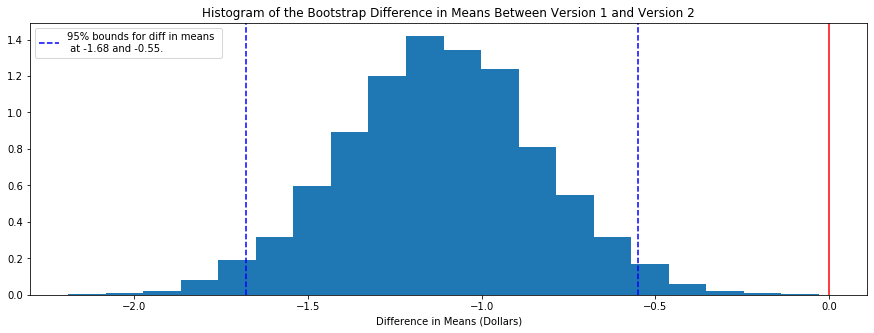

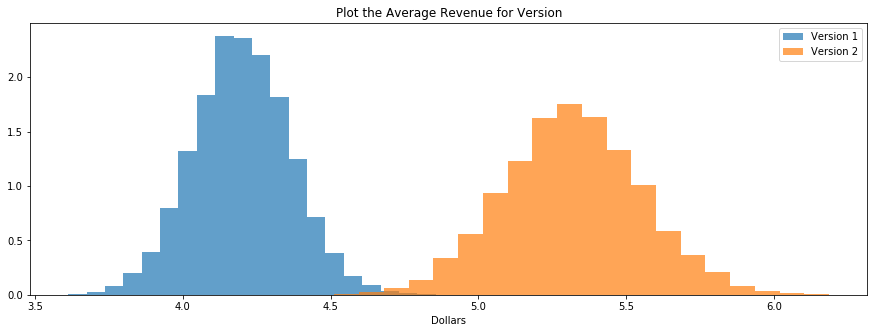

In [11]:
def plot_results(diffs, revs1, revs2):
    '''
    inputs:
        diffs: (list) difference in the average revenue for page_versions
        rev_avgs_1: (list) average revenue for page_version 1
        rev_avgs_2: (list) average revenue for page_version 2
    returns: 
        None
    '''
    ### diffs hist ###
    # create the figure size
    plt.figure(figsize=(15,5))

    # find lower and upper bounds
    upper = np.round(np.percentile(diffs, 97.5), 2)
    lower = np.round(np.percentile(diffs, 2.5), 2)
    print(upper, lower)
    
    # plot lower, upper, and null value
    plt.axvline(upper, 0, 1, color='blue', linestyle = '--', label='95% bounds for diff in means \n at {} and {}.'.format(np.round(lower,2), np.round(upper,2)))
    plt.axvline(lower, 0, 1, color='blue', linestyle = '--')
    plt.axvline(0, 0, 1, color='red')

    # plot diffs
    plt.hist(diffs, bins=20, density=True);
    plt.title('Histogram of the Bootstrap Difference in Means Between Version 1 and Version 2');
    plt.xlabel('Difference in Means (Dollars)');
    plt.grid(False);

    plt.legend();
    plt.show();
    
    ### average hists ###
    # create the figure size
    plt.figure(figsize=(15,5))
    
    plt.hist(revs1, bins=20, label='Version 1', alpha=0.7, density=True);
    plt.hist(revs2, bins=20, label='Version 2', alpha=0.7, density=True);
    plt.title('Plot the Average Revenue for Version');
    plt.xlabel('Dollars');
    plt.grid(False);
        
    plt.legend();
    plt.show();
    
plot_results(diffs, rev_avgs_1, rev_avgs_2)

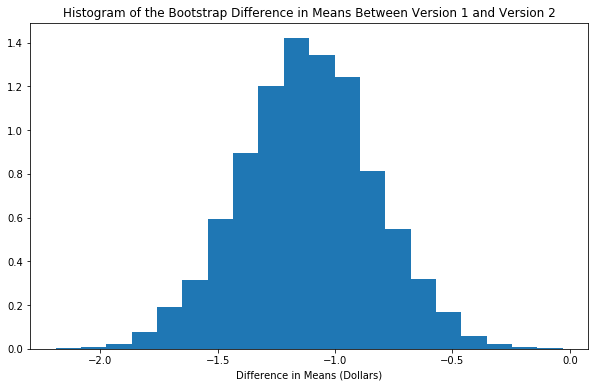

In [50]:
    plt.figure(figsize=(15,5))

    upper = np.round(np.percentile(diffs, 97.5), 2)
    lower = np.round(np.percentile(diffs, 2.5), 2)
    plt.axvline(upper, 0, 1, color='blue', linestyle = '--', label='95% bounds for diff in means \n at {} and {}.'.format(np.round(lower,2), np.round(upper,2)))
    plt.axvline(lower, 0, 1, color='blue', linestyle = '--')
    plt.axvline(0, 0, 1, color='red')

    plt.hist(diffs, bins=20, density=True);
    plt.title('Histogram of the Bootstrap Difference in Means Between Version 1 and Version 2');
    plt.xlabel('Difference in Means (Dollars)');
    plt.grid(False);

    plt.legend();
    plt.show();

In [25]:
def create_data(version_1_sample=1200, version_2_sample=1200):
    '''
    inputs:
        version_1_sample: (int) number of people given landing page version 1
        version_2_sample: (int) number of people given landing page version 2

    returns:
        df: (DataFrame) with the description given below
        
    This function builds a dataframe with columns for:

                |              |              |         |
        user_id | page_version | clickthrough | convert | revenue
        ----------------------------------------------------------

    user_id: (int) a unique user id
    page_version: (int) the page version is either landing page version 1 or 2
    clickthrough: (int) is whether or not the user clicked through the homepage 0 or 1
    convert: (int) is whether or not the user converted 0 or 1
    revenue: (int) is a dollar amount associated with the product conversion amount
    
    '''
    np.random.seed(42) # set the seed to always create the same dataframe
    df = pd.DataFrame() # create an empty dataframe to store the results

    # create user and version columns
    df['user_id'] = list(range(version_1_sample + version_2_sample))
    df['page_version'] = list(np.repeat(1, version_1_sample)) + list(np.repeat(2, version_2_sample))

    # values for the convert column
    result_1 = np.random.binomial(1, 0.001, version_1_sample)
    result_2 = np.random.binomial(1, 0.0015, version_2_sample)
    df['convert'] = list(result_1) + list(result_2)

    # values for the clickthrough from the landing page
    df['clickthrough'] = df['convert']
    for idx in df.query('clickthrough == 0').index:
        df.loc[idx, 'clickthrough'] = np.random.binomial(1, 0.3, 1)[0]

    # values for the revenue column
    df['revenue'] = 0
    product_prices = [20, 40, 60, 80, 100, 150]
    odds_result_1 = [0.5, 0.2, 0.1, 0.1, 0.05, 0.05]
    odds_result_2 = [0.3, 0.1, 0.1, 0.1, 0.2, 0.2]
    for idx in df.query('convert == 1 and page_version == 1').index:
        df.loc[idx, 'revenue'] = np.random.choice(product_prices, 1, p=odds_result_1)    
    for idx in df.query('convert == 1 and page_version == 2').index:
        df.loc[idx, 'revenue'] = np.random.choice(product_prices, 1, p=odds_result_2)    

    # shuffle the order of the dataframe  rows and reorder the columns
    df = df.sample(frac=1, random_state=42)
    df = df[['user_id', 'page_version', 'clickthrough', 'convert' , 'revenue']]

    return df

df = create_data(1000, 1000)
df.head()

,user_id,page_version,clickthrough,convert,revenue
1860,1860,2,0,0,0
353,353,1,1,0,0
1333,1333,2,0,0,0
905,905,1,0,0,0
1289,1289,2,1,0,0


In [26]:
df.query('page_version == 1')['convert'].mean(), df.query('page_version == 1')['convert'].std()

(0.001, 0.03162277660168402)

In [28]:
0.001 + 2*(0.03162277660168402/np.sqrt(1000)), 0.001 - 2*(0.03162277660168402/np.sqrt(1000)) 

(0.0030000000000000144, -0.0010000000000000143)

In [38]:
def bootstrap_function_ctr(df, num_samples=10000):
    ctrs = []
    for idx in range(num_samples):
        df_sample = df.sample(n=df.shape[0], replace=True)
        ctr = df_sample.query('page_version == 1')['convert'].mean()
        
        ctrs.append(ctr)
        
    return ctrs

ctrs = bootstrap_function_ctr(df)

0.0031 0.0


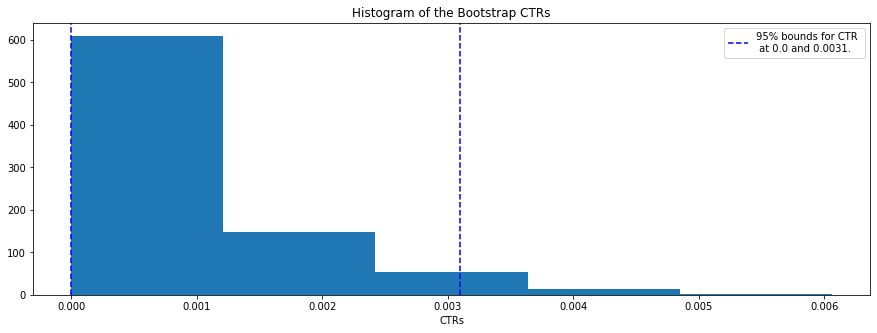

In [40]:
def plot_results(ctrs):
    '''
    inputs:
        diffs: (list) difference in the average revenue for page_versions
        rev_avgs_1: (list) average revenue for page_version 1
        rev_avgs_2: (list) average revenue for page_version 2
    returns: 
        None
    '''
    ### diffs hist ###
    # create the figure size
    plt.figure(figsize=(15,5))

    # find lower and upper bounds
    upper = np.round(np.percentile(ctrs, 97.5), 4)
    lower = np.round(np.percentile(ctrs, 2.5), 4)
    print(upper, lower)
    
    # plot lower, upper, and null value
    plt.axvline(upper, 0, 1, color='blue', linestyle = '--', label='95% bounds for CTR \n at {} and {}.'.format(np.round(lower,4), np.round(upper,4)))
    plt.axvline(lower, 0, 1, color='blue', linestyle = '--')


    # plot diffs
    plt.hist(ctrs, bins=5, density=True);
    plt.title('Histogram of the Bootstrap CTRs');
    plt.xlabel('CTRs');
    plt.grid(False);

    plt.legend();
    plt.show();

    
plot_results(ctrs)